# Dave's FAA Aircraft Characteristics Data practice data science project
---
## Objectives
### Meta (why I'm doing this at all)
* Show off some data science skills on a project with public sources without NDA/IP issues
* Demonstrate ability to do self-guided data science work
* Demonstrate step-by-step thinking and documentation
### Project (the goals of the data science here)
* Develop models that can "fill in the blank" and predict aircraft attributes if others are known
* Predict flight attributes from stationary features
* Predict manufacturer
* Predict # of IFR operations
---
## Outline 
#### Exploratory data analysis and data cleaning
* Understand contents of the database
* Make decisions about missing and bad data
* explore potential features and targets for models
* explore statistical properties of numerical variables
* select and perform transforms on features 
---
## Data Source
https://www.faa.gov/airports/engineering/aircraft_char_database/data

## **Offline pre-processing**
* Renamed .xlsx file to FAA.csv
---
## **Load data and assess contents**

In [126]:
# all the imports for the project
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [127]:
# import xlsx file
df = pd.read_excel('FAA.xlsx',sheet_name='ACD_Data')

# summaraize dataframe structure and contents 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 56 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   ICAO_Code                               387 non-null    object 
 1   FAA_Designator                          387 non-null    object 
 2   Manufacturer                            387 non-null    object 
 3   Model_FAA                               387 non-null    object 
 4   Model_BADA                              386 non-null    object 
 5   Physical_Class_Engine                   387 non-null    object 
 6   Num_Engines                             387 non-null    int64  
 7   AAC                                     384 non-null    object 
 8   AAC_minimum                             11 non-null     object 
 9   AAC_maximum                             11 non-null     object 
 10  ADG                                     387 non-null    object

#### So now we see the columns of the database. It's a combination of categorical and numerical variables. 
#### But also some total garbage we can get rid of right away -- all of those columns called Unnamed are empty 

In [128]:
# drop columns containing "Unnamed" 
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# summaraize dataframe structure and contents 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 40 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   ICAO_Code                               387 non-null    object 
 1   FAA_Designator                          387 non-null    object 
 2   Manufacturer                            387 non-null    object 
 3   Model_FAA                               387 non-null    object 
 4   Model_BADA                              386 non-null    object 
 5   Physical_Class_Engine                   387 non-null    object 
 6   Num_Engines                             387 non-null    int64  
 7   AAC                                     384 non-null    object 
 8   AAC_minimum                             11 non-null     object 
 9   AAC_maximum                             11 non-null     object 
 10  ADG                                     387 non-null    object

#### So now at least it seems we've imported the sheet to a dataframe ok
* For starters, each row is a type of airplane. 
* The columns (variables) are different attributes of the airplane.
* Some of the attributes have values in every instance, some of them have missing values. Understanding what they are will help us understand why and what to do.
#### Luckily, we don't have to figure out what all of these mean; the excel file came with a second book with definitions, let's import it
* I'm going to cheat a little bit and do some cleaning based on what I know about the structure from excel

In [129]:
dd = pd.read_excel('FAA.xlsx',sheet_name=1)
dd = dd.iloc[0:39,:]

# re-index dataframe by Characteristic (name of column in df)
dd = dd.set_index('Characteristic')
print(dd.info())
dd.head()

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, ICAO_Code to Total_IFR_Operations_2021_2022
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Full Elaboration   39 non-null     object
 1   Unit               39 non-null     object
 2   Note               32 non-null     object
 3   Reference          39 non-null     object
 4   Link to Reference  26 non-null     object
dtypes: object(5)
memory usage: 1.8+ KB
None


,Full Elaboration,Unit,Note,Reference,Link to Reference
Characteristic,,,,,
ICAO_Code,International Civil Aviation Organization (ICA...,Not Applicable,Standard abbreviations for aircraft assigned b...,ICAO Website,https://www.icao.int/publications/doc8643/page...
FAA_Designator,Federal Aviation Administration (FAA) Aircraft...,Not Applicable,Standard abbreviations for aircraft assigned b...,FAA Order JO 7360.1G,https://www.faa.gov/regulations_policies/order...
Manufacturer,Aircraft Manufacturer Name,Not Applicable,Name of the aircraft manufacturer. In some cas...,FAA Order JO 7360.1G,https://www.faa.gov/regulations_policies/order...
Model_FAA,FAA Aircraft Model Name,Not Applicable,NaN,FAA Order JO 7360.1G,https://www.faa.gov/regulations_policies/order...
Model_BADA,Euecontrol Base of Aircraft Data (BADA) Aircra...,Not Applicable,NaN,BADA Aircraft Performance Database,https://contentzone.eurocontrol.int/aircraftpe...


So we can see, now the dd dataframe has the column names of df as rows, and the definition is in the "Full Elaboration" column
---
## EDA: targets and features consideration
There are several column (vars) categorizations to consider:
* **Flight vars**: numerical characteristics of the airplane, in flight. Potential interesting targets. takeoff weight, approach speed, etc
* **Numerical Ground vars**: characteristics of the airplane, not necessarily involving flight. e.g., length, # of engines
* **Categorical Ground vars**: things like type of engine, manufacturer
* **UID vars**: columns that unique identify the airplane
* **Bureaucratic classes** columns that specify some arbitrary class, e.g. AAC. 

In [130]:
# reset index of dataframe to ICAO_Code
df = df.set_index('ICAO_Code')

# get numerical column names from df
num_cols = df.select_dtypes(include=['float64','int64']).columns

# print the names and how many missing values are in each column
print(df[num_cols].isnull().sum())

Num_Engines                                 0
Approach_Speed_knot                         3
Approach_Speed_minimum_knot               376
Approach_Speed_maximum_knot               376
Wingspan_ft_without_winglets_sharklets     13
Wingspan_ft_with_winglets_sharklets       362
Length_ft                                   0
Tail_Height_at_OEW_ft                       0
Wheelbase_ft                                0
Cockpit_to_Main_Gear_ft                     0
Main_Gear_Width_ft                          0
MTOW_lb                                     0
MALW_lb                                    21
Parking_Area_ft2                            0
Rotor_Diameter_ft                         386
LAHSO                                      69
Registration_Count                          0
Total_IFR_Operations_2021_2022              0
dtype: int64


a few things
* one row is a helicopter, let's drop that
* what's the deal with the 3 rows with missing approach speed?
* how to deal with this with/without sharklets issue?
* why is max landing weight missing for some?
* what's going on with LAHSO? (this one is easy: it's actually a bureaucratic variable that's encoded numerically)

In [131]:
# list the unique values in Physical_Class_Engine and their counts
print(df['Physical_Class_Engine'].value_counts())

#  find the row where Physical_Class_Engine is 'Turboshaft' and drop it
df = df[df['Physical_Class_Engine'] != 'Turboshaft']

# remove the rotor_diameter_ft column
df = df.drop(columns='Rotor_Diameter_ft',axis=1)

# do df.head for the rows where Approach_Speed_knot is missing
df[df['Approach_Speed_knot'].isnull()].head()

Physical_Class_Engine
Jet           185
Piston        129
Turboprop      72
Turboshaft      1
Name: count, dtype: int64


,FAA_Designator,Manufacturer,Model_FAA,Model_BADA,Physical_Class_Engine,Num_Engines,AAC,AAC_minimum,AAC_maximum,ADG,...,CWT,One_Half_Wake_Category,Two_Wake_Category_Appx_A,Two_Wake_Category_Appx_B,SRS,LAHSO,FAA_Registry,Registration_Count,Total_IFR_Operations_2021_2022,Remarks
ICAO_Code,,,,,,,,,,,,,,,,,,,,,
CL41,CL41,CANADAIR,Canadair 41 Tutor,Canadair CL-41 Tutor,Jet,1,NaN,NaN,NaN,I,...,I,F,F,F,III,NaN,Yes,1,900,NaN
COUR,COUR,HELIO,HELIO U-10 Super Courier,HELIO H-295 Super Courier,Piston,1,NaN,NaN,NaN,I,...,I,F,F,F,I,1.0,Yes,3,160,NaN


In [132]:
# ok so those rows are ultra-rare aircraft (see registration count), so we can drop them
df = df.dropna(subset=['Approach_Speed_knot'])

# now see where we're at again
# print the names and how many missing values are in each column
num_cols = df.select_dtypes(include=['float64','int64']).columns
print(df.shape)
print(df[num_cols].isnull().sum())

(384, 38)
Num_Engines                                 0
Approach_Speed_knot                         0
Approach_Speed_minimum_knot               373
Approach_Speed_maximum_knot               373
Wingspan_ft_without_winglets_sharklets     13
Wingspan_ft_with_winglets_sharklets       359
Length_ft                                   0
Tail_Height_at_OEW_ft                       0
Wheelbase_ft                                0
Cockpit_to_Main_Gear_ft                     0
Main_Gear_Width_ft                          0
MTOW_lb                                     0
MALW_lb                                    19
Parking_Area_ft2                            0
LAHSO                                      67
Registration_Count                          0
Total_IFR_Operations_2021_2022              0
dtype: int64


OK, so now onto questions around Wingspan: we're going to take the average if figures for with and without winglets are available, otherwise whichever is available

In [133]:
# for rows where Wingspan_ft_without_winglets_sharklets is missing, fill in the value from Wingspan_ft_with_winglets_sharklets
df.fillna({'Wingspan_ft_without_winglets_sharklets': df['Wingspan_ft_with_winglets_sharklets']}, inplace=True)
# for rows where Wingspan_ft_with_winglets_sharklets is missing, fill in the value from Wingspan_ft_without_winglets_sharklets
df.fillna({'Wingspan_ft_with_winglets_sharklets': df['Wingspan_ft_without_winglets_sharklets']}, inplace=True)
# make new column Wingspan_ft that is the average of the two
df['Wingspan_ft'] = (df['Wingspan_ft_without_winglets_sharklets'] + df['Wingspan_ft_with_winglets_sharklets'])/2
# drop the two original columns, also LAHSO
df.drop(columns=['Wingspan_ft_without_winglets_sharklets','Wingspan_ft_with_winglets_sharklets','LAHSO','Approach_Speed_minimum_knot','Approach_Speed_maximum_knot'],axis=1,inplace=True)
print(df.shape)
num_cols = df.select_dtypes(include=['float64','int64']).columns
print(df[num_cols].isnull().sum())


(384, 34)
Num_Engines                        0
Approach_Speed_knot                0
Length_ft                          0
Tail_Height_at_OEW_ft              0
Wheelbase_ft                       0
Cockpit_to_Main_Gear_ft            0
Main_Gear_Width_ft                 0
MTOW_lb                            0
MALW_lb                           19
Parking_Area_ft2                   0
Registration_Count                 0
Total_IFR_Operations_2021_2022     0
Wingspan_ft                        0
dtype: int64


OK so now things are looking pretty good. We've addressed most of the columns that had missing values except MALW_lb, which is missing for 19 planes
Let's go ahead and look at how these variables are distributed and what structure we see in terms of pair-wise correlations.

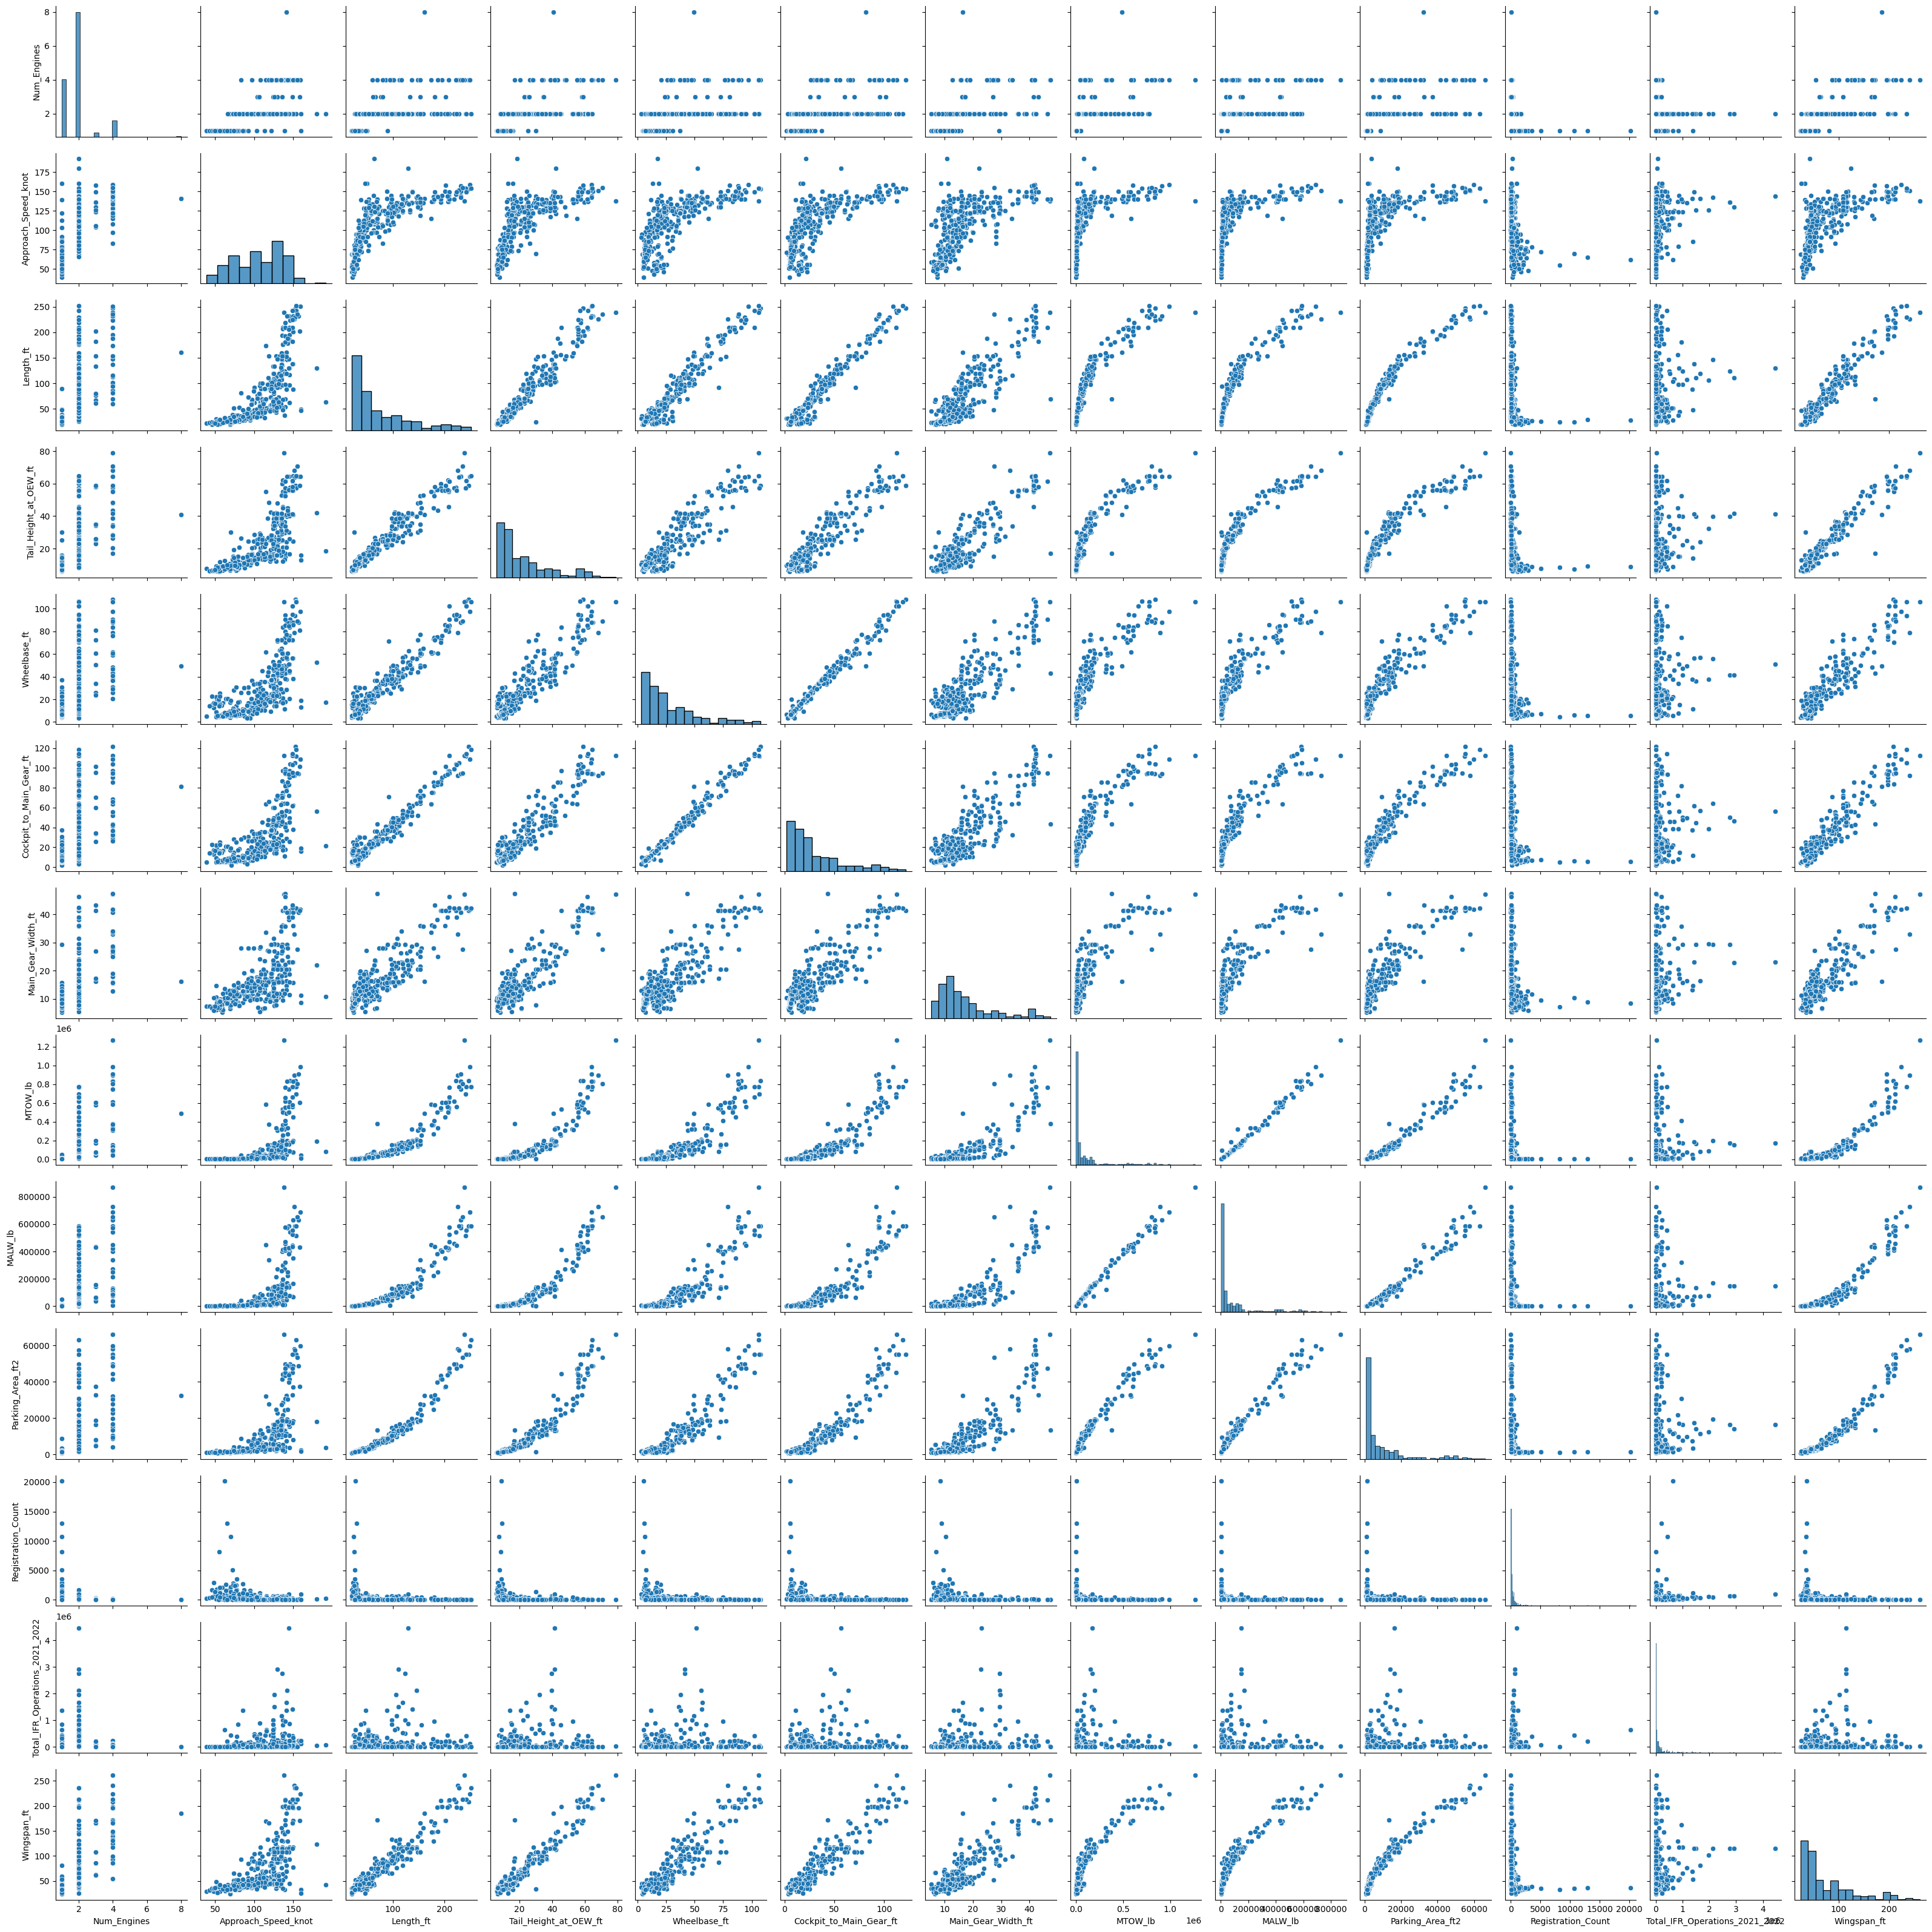

In [134]:
# do the big sns pairplot
sns.pairplot(df[num_cols])
plt.show()


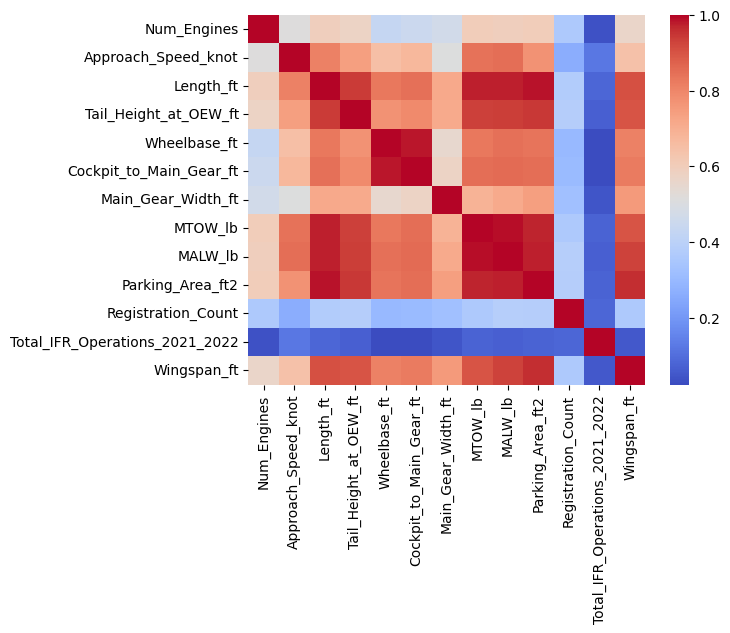

In [135]:
# use seaborn to make a heatmap of the correlation r squared matrix using spearman method since most of the data is not normally distributed
corr = df[num_cols].corr(method='spearman')
# get square of corr
corr = corr**2
# make heatmap, use colormap 'coolwarm'

sns.heatmap(corr, cmap='coolwarm')
plt.show()


A few things immediately pop out in the above two diagrams:
* Two variables, Registration_Count and Total_IFR_Operations, are much less correlated with other columns. These describe statistics about usage, whereas the rest are properties of the aircraft
* The rest of the variables are at least moderately correlated with one another. All except Approach_Speed_knot describe the size of the plane in some way, so this makes sense.
* Num_Engines also less correlated but that's because it's in fact an ordinal variable here
* Most of these distributions don't look Gaussian, but that could be because they're a mixture of multiple distributions from distinct classes of planes
* MALW_lb is so highly correlated with MTOW_lb that we should be able to impute the missing values
---
Let's explore imputing MALW_lb

In [136]:
# List rows where MALW_lb is missing
df[df['MALW_lb'].isnull()].head(19)

,FAA_Designator,Manufacturer,Model_FAA,Model_BADA,Physical_Class_Engine,Num_Engines,AAC,AAC_minimum,AAC_maximum,ADG,...,CWT,One_Half_Wake_Category,Two_Wake_Category_Appx_A,Two_Wake_Category_Appx_B,SRS,FAA_Registry,Registration_Count,Total_IFR_Operations_2021_2022,Remarks,Wingspan_ft
ICAO_Code,,,,,,,,,,,,,,,,,,,,,
A10,A10,FAIRCHILD,Fairchild A10,Fairchild A-10A,Jet,2,C,NaN,NaN,II,...,G,E,D,D,III,Yes,281,33752,NaN,57.5
B2,B2,NORTHROP,Northrop B-2 Spirit,Northrop B-2 Spirit,Jet,4,C,NaN,NaN,V,...,D,C,G,G,III,Yes,21,4292,NaN,172.0
B52,B52,BOEING,Boeing B-52 Stratofortress,Boeing B-52 Stratofortress,Jet,8,D,NaN,NaN,V,...,D,B,G,G,III,Yes,80,9641,NaN,185.0
BE50,BE50,BEECH,Beechcraft 50 Twin Bonanza,Beech 50 Twin Bonanza,Piston,2,A,NaN,NaN,I,...,I,F,F,F,II,Yes,123,1549,NaN,45.3
BE95,BE95,BEECH,Beechcraft 95 Travel Air,Beech 95 Travel Air,Piston,2,A,NaN,NaN,II,...,I,F,F,F,II,Yes,262,5346,NaN,37.8
BL8,BL8,BELLANCA,Bellanca 8 Scout,Bellanca 8 Scout,Piston,1,A,NaN,NaN,I,...,I,F,F,F,I,Yes,180,318,NaN,36.2
DHC2,DHC2,DEHAVILLAND CANADA,DeHavilland Canada 2 Mk1 Beaver,DeHavilland Canada DHC-2 Beaver,Piston,1,A,NaN,NaN,I,...,I,F,F,F,I,Yes,228,336,NaN,48.0
F15,F15,BOEING-MCDONNELL DOUGLAS,Boeing F-15 Eagle,McDonnell Douglas F-15E,Jet,2,E,NaN,NaN,I,...,G,E,D,D,III,Yes,249,77917,NaN,42.8
F16,F16,LOCKHEED-GENERAL DYNAMICS,Lockheed F-16 Fighting Falcon,General Dynamics F-16C,Jet,1,D,NaN,NaN,I,...,G,E,D,D,III,Yes,1017,126046,NaN,32.7


* For the most part, these appear to be military aircraft, but a few GA planes are in here too
* Some jets, some props, some big, some small -- there's no obvious common factor or anything that would justify dropping these
---
Taking another look at the correlation matrix above, MALW is highly correlated with MTOW, parking area, and length
Let's zoom in on the correlations of these variables

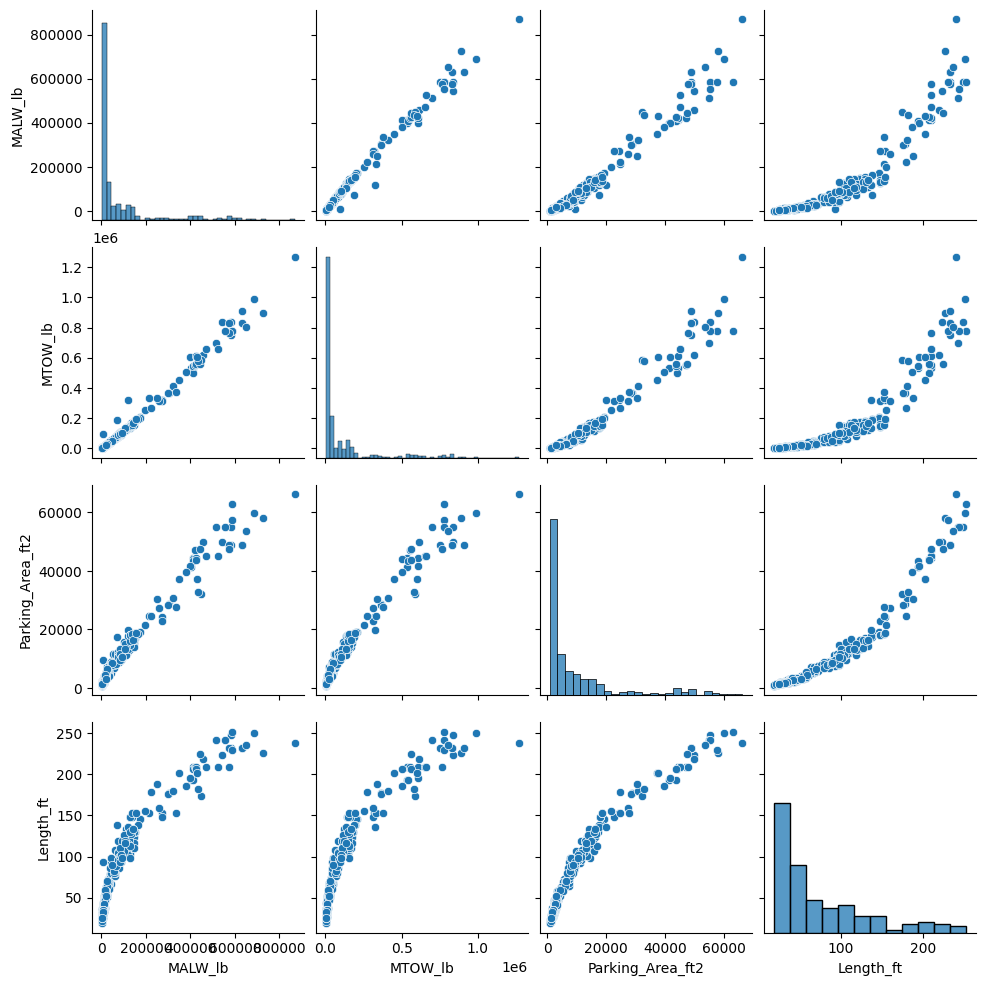

In [137]:
df_MALWmodel = df[['MALW_lb','MTOW_lb','Parking_Area_ft2','Length_ft']].copy()
df_MALWmodel.dropna(inplace=True)
sns.pairplot(df_MALWmodel)
plt.show()

So now we're going to do linear regression to predict MALW_lb using the other 3, and use k-folds cross validation  

e:\Documents\GitHub\Dave_ML\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.703e+10, tolerance: 5.470e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
e:\Documents\GitHub\Dave_ML\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.079e+10, tolerance: 6.409e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemente

0.9911507180870677 {'elastic__alpha': np.float64(24.244620170823282), 'elastic__l1_ratio': np.float64(1.0), 'elastic__max_iter': 100000, 'elastic__selection': 'cyclic', 'elastic__tol': 0.001, 'elastic__warm_start': False}
0.9924059651715711


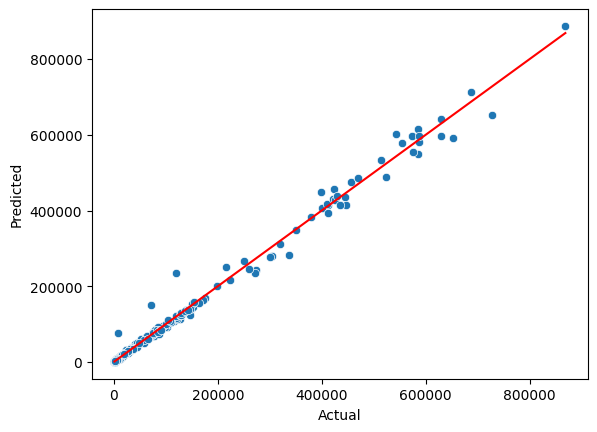

In [145]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import numpy as np

# split the data into training and testing sets
X = df_MALWmodel[['MTOW_lb','Parking_Area_ft2','Length_ft']]
y = df_MALWmodel['MALW_lb']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

estimator = Pipeline([
    ('scaler', StandardScaler()),       # Step to standardize features
    ('elastic', ElasticNet())           # Step to fit ElasticNet model                 
])

# np linspace from .001 to 1 by .001
alphas = np.geomspace(0.01, 100, num=40)
ratios = np.linspace(0, 1, num=20)

params = {
    'elastic__alpha': alphas,
    'elastic__l1_ratio': ratios,
    'elastic__max_iter': [100000],
    'elastic__tol': [1e-3],
    'elastic__selection': ['cyclic'],
    'elastic__warm_start': [False]
   
}

grid = GridSearchCV(estimator, params, cv=kf)
grid.fit(X, y)
print(grid.best_score_, grid.best_params_)
y_pred = grid.predict(X)
print(r2_score(y, y_pred))
# plot the predicted vs actual values
sns.scatterplot(x=y, y=y_pred)
# draw a line from the bottom left to the top right
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red')
plt.xlabel('Actual MALW (lb)')
plt.ylabel('Predicted MALW (lb)')
plt.show()

[118368.94171242  28657.78363178   3515.38986051]


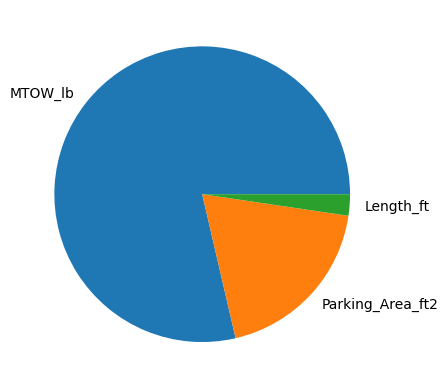

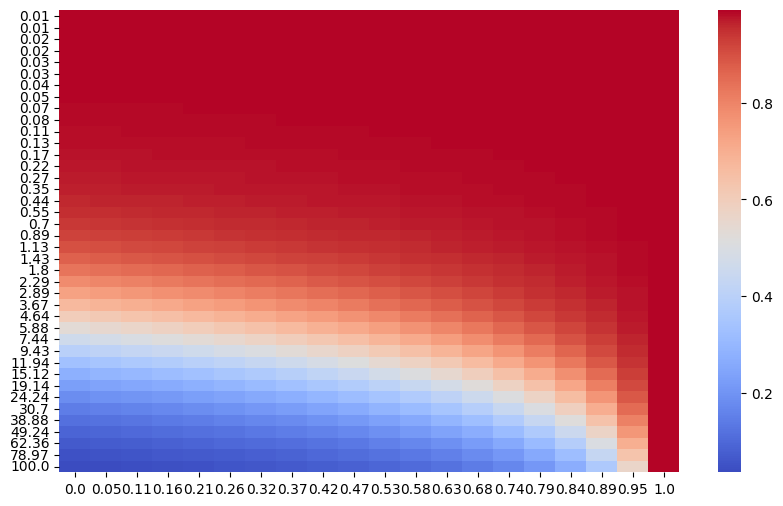

In [146]:
# print best coefficients
print(grid.best_estimator_['elastic'].coef_)
# make pie chart of coefficients
plt.pie(np.abs(grid.best_estimator_['elastic'].coef_), labels=X.columns)
plt.show()

scores = grid.cv_results_['mean_test_score']



# reshape the scores to a 2D array
scores = scores.reshape(len(alphas),len(ratios))


# round alphas so they're easier to read

# make a heatmap of the scores
plt.figure(figsize=(10, 6))
ax = sns.heatmap(scores, cmap='coolwarm', xticklabels=np.round(ratios,2), yticklabels=np.round(alphas, 2))
# adjust the aspect ratio so it's not squished


ax.set_aspect('auto')

plt.show()


In [140]:
# now time for categorical eda
# get the categorical columns
cat_cols = df.select_dtypes(include=['object']).columns

# print number of unique values in each column
for col in cat_cols:
    print(col, df[col].nunique())

# print number of null values in each column
print(df[cat_cols].isnull().sum())

FAA_Designator 384
Manufacturer 88
Model_FAA 384
Model_BADA 382
Physical_Class_Engine 3
AAC 5
AAC_minimum 2
AAC_maximum 2
ADG 6
TDG 9
Main_Gear_Config 13
ICAO_WTC 6
Class 2
FAA_Weight 5
CWT 9
One_Half_Wake_Category 6
Two_Wake_Category_Appx_A 7
Two_Wake_Category_Appx_B 7
SRS 3
FAA_Registry 3
Remarks 14
FAA_Designator                0
Manufacturer                  0
Model_FAA                     0
Model_BADA                    1
Physical_Class_Engine         0
AAC                           0
AAC_minimum                 373
AAC_maximum                 373
ADG                           0
TDG                           0
Main_Gear_Config              0
ICAO_WTC                      0
Class                         0
FAA_Weight                    0
CWT                           0
One_Half_Wake_Category        0
Two_Wake_Category_Appx_A      3
Two_Wake_Category_Appx_B      3
SRS                           0
FAA_Registry                  0
Remarks                     256
dtype: int64
